In [3]:
!unzip processed.zip -d ./semantic_drone_dataset
!pip install git+https://github.com/tensorflow/examples.git

Archive:  processed.zip
   creating: ./semantic_drone_dataset/processed/
  inflating: ./semantic_drone_dataset/processed/.DS_Store  
  inflating: ./semantic_drone_dataset/__MACOSX/processed/._.DS_Store  
   creating: ./semantic_drone_dataset/processed/images/
   creating: ./semantic_drone_dataset/processed/label_images/
   creating: ./semantic_drone_dataset/processed/.ipynb_checkpoints/
  inflating: ./semantic_drone_dataset/processed/images/348.png  
  inflating: ./semantic_drone_dataset/processed/images/374.png  
  inflating: ./semantic_drone_dataset/processed/images/360.png  
  inflating: ./semantic_drone_dataset/processed/images/176.png  
  inflating: ./semantic_drone_dataset/processed/images/162.png  
  inflating: ./semantic_drone_dataset/processed/images/189.png  
  inflating: ./semantic_drone_dataset/processed/images/002.png  
  inflating: ./semantic_drone_dataset/processed/images/016.png  
  inflating: ./semantic_drone_dataset/processed/images/228.png  
  inflating: ./semantic_d

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import pandas as pd

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
from glob import glob
import os

## Loading Data

In [2]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom generator for use with image segmentation. Initiating the generator requires the folders and file lists for images
    and masks. 
    
    """
    
    def __init__(self, img_folder,mask_folder, img_path, mask_path, batch_size=16, dim=[224,224], augment=None, shuffle=True, 
                validation_split = 0.0, subset = None):
        'Initialization'
        self.dim = dim        
        # Create train and validation splits in the data generation            
        split = int(np.floor(len(img_path) * (1-validation_split)))
        if subset == 'Train':
            self.img_path = img_path[:split]
            self.mask_path = mask_path[:split]
        elif subset == 'Valid':
            self.img_path = img_path[split:]
            self.mask_path = mask_path[split:]
        else:
            self.img_path = img_path
            self.mask_path = mask_path
            
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Generate the number of batches created
        """
        return int(np.floor(len(self.img_path) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        # Add augmented images to dataset from augment input
        if self.augment is None:
            return X, y
        else:
            im, mask = [], []
            for x, y in zip(X, y):
                im.append(x)
                mask.append(to_categorical(y, num_classes = 24))
                for augment in self.augment:
                  augmented = augment(image=x, mask=y)
                  im.append(augmented['image'])
                  mask.append(to_categorical(augmented['mask'], num_classes = 24))
            return np.array(im), np.array(mask)     
            
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_path))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        batch_imgs = []
        batch_labels = []

        # Generate data
        for i in list_IDs_temp:

            img_file = tf.io.read_file(self.img_folder + self.img_path[i])
            img = tf.image.decode_png(img_file, channels=3, dtype=tf.uint8)
            img = tf.image.resize(img, self.dim, method='nearest')
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label_file = tf.io.read_file(self.mask_folder + self.mask_path[i])
            label = tf.image.decode_png(label_file, channels=1, dtype=tf.uint8)
            label = tf.image.resize(label, self.dim, method='nearest')
            if self.augment is None:
              label = to_categorical(label , num_classes = 24)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [3]:
# Create a list of transformations to apply to images and masks
transform = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Sharpen()
]

In [4]:
img_folder = './semantic_drone_dataset/processed/images/'
mask_folder = './semantic_drone_dataset/processed/label_images/'

In [5]:
img_files = np.sort(os.listdir(img_folder))
mask_files = np.sort(os.listdir(mask_folder))

In [6]:
train_generator = DataGenerator(img_folder, mask_folder, img_files, mask_files,batch_size=16, augment=transform, dim=[224, 224] ,shuffle=True, validation_split=0.2, subset='Train')
val_generator = DataGenerator(img_folder, mask_folder, img_files, mask_files,batch_size=16, augment=transform, dim=[224, 224] ,shuffle=True, validation_split=0.2, subset='Valid')


For the amount

In [7]:
def mask_encoding(masks, size = 224):
    """
    One Hot encode the class value for mask images
    """
    oh_masks = []
    out_shape = (size, size, 24)
    for mask in masks:
        oh_mask = tf.one_hot(mask, depth=24, axis=3)
        oh_mask = tf.reshape(oh_mask, out_shape)
        oh_masks.append(oh_mask)

    return oh_masks

In [8]:
def mask_decoding(masks, size = 224):
    """
    Undo the one hot encoding for masks. Used for creating images from model predictions. 
    """
    class_masks = []
    out_shape = (size, size, 1)
    for mask in masks:
        class_mask = tf.argmax(tf.reshape(mask, (size, size, 24)), axis=2)
        class_mask = tf.reshape(class_mask, out_shape)
        class_masks.append(class_mask)

    return class_masks

## Segmentation Metrics

[code](https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras)

In [9]:
def dice_coef(y_true, y_pred, smooth=10):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [10]:
def dice_coef_multilabel(y_true, y_pred, M=24, smooth=10):
    dice = 0
    for index in range(M):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index], smooth)
    return dice

def dice_coef_multilabel_loss(y_true, y_pred):
    return 1 - dice_coef_multilabel(y_true, y_pred)

### Modeling Checkpoints

In [11]:
def display(display_list, name='None', epoch=0):

  fig = plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  file_name = name + '_' + str(epoch) + '_' + 'pred_mask.png' 
  fig.savefig('./imgs/' + file_name)
  plt.show()

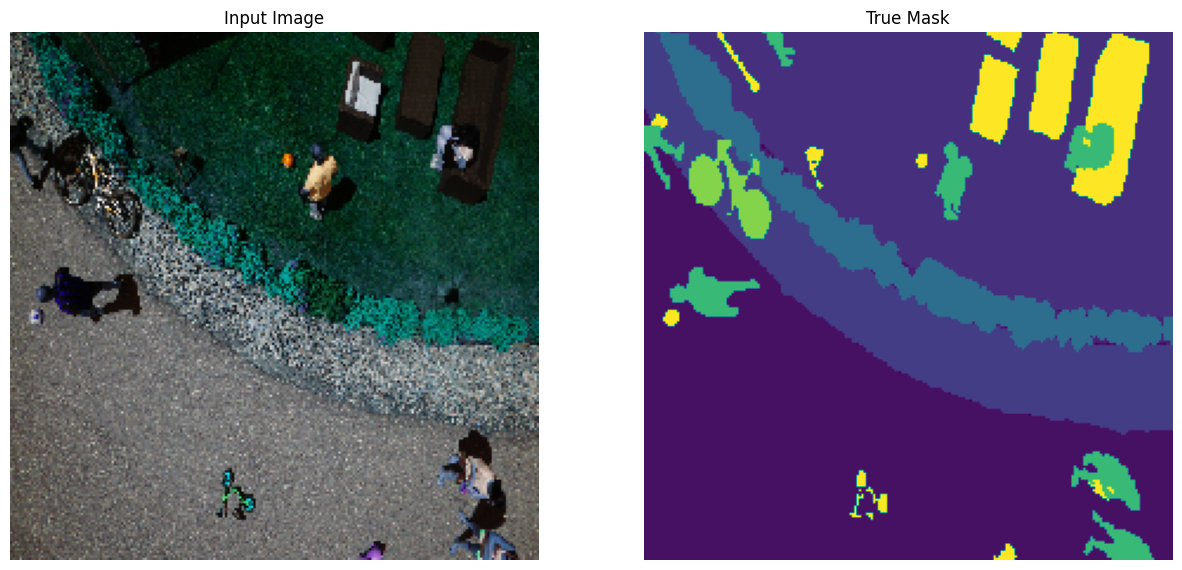

In [12]:
im, mk = train_generator.__getitem__(1)
sample_image, sample_mask = im[0], mask_decoding(mk)[0]
display([sample_image, sample_mask])


In [13]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
      pred = self.model.predict(sample_image[tf.newaxis, ...])
      pred = mask_decoding(pred)[0]
      clear_output(wait=True)
      display([sample_image, sample_mask, pred], self.model.name, epoch)
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Baseline Model

In [14]:
base_generator = DataGenerator(img_folder, mask_folder, img_files, mask_files,batch_size=400, dim=[224, 224])
base_x, base_y = base_generator.__getitem__(0)
mk_class, idx, count = tf.unique_with_counts(
    K.flatten(mask_decoding(base_y)),
    out_idx=tf.dtypes.int32
)

In [15]:
df = {'class':mk_class.numpy(), 'count':count.numpy()}
df = pd.DataFrame(df)
df['count_pct'] = df['count']/df['count'].sum()

In [16]:
df.sort_values(by='count', ascending=False).head()

,class,count,count_pct
2,1,7549861,0.376169
14,3,3995191,0.199059
10,9,1468127,0.073149
4,4,1458750,0.072682
6,8,1418522,0.070677


## U-Net Model

In [17]:
def unet_model(output_channels:int, size = 224, name=None):
    """
    Create the setup for the U-net model. The encoder will be based on the MobileNetV2 pretrained model, and then and encoder 
    will be created using the 
    """

    base_model = tf.keras.applications.MobileNetV2(input_shape=[size, size, 3], include_top=False)
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input


    # Use the activations of these layers
    layer_names = [
      'block_1_expand_relu',   
      'block_3_expand_relu',  
      'block_6_expand_relu',  
      'block_13_expand_relu', 
      'block_16_project',      
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3, apply_dropout=True),
    pix2pix.upsample(64, 3, apply_dropout=True),  
    ]


    inputs = tf.keras.layers.Input(shape=[size, size, 3])
    inputs = preprocess_input(inputs)


    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last_up = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')

   
    x = last_up(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(output_channels, 3, padding='same', activation='softmax')(x)
    
    

    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

Dice Coef Loss Model

In [18]:
OUTPUT_CLASSES = 24


model = unet_model(output_channels=OUTPUT_CLASSES, name='dice_seg')
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=dice_coef_multilabel_loss,
              metrics=['acc',
                       tf.keras.metrics.MeanIoU(num_classes=24, sparse_y_pred=False, sparse_y_true=False)])

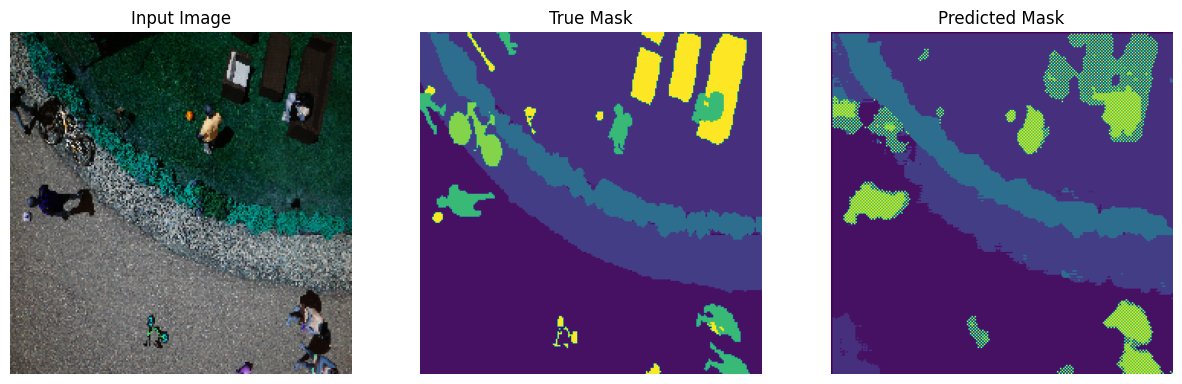


Sample Prediction after epoch 51

20/20 [==============================] - 37s 2s/step - loss: -11.5590 - acc: 0.7399 - mean_io_u: 0.3644 - val_loss: -8.7237 - val_acc: 0.7068 - val_mean_io_u: 0.2654


In [19]:
EPOCHS = 51

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('seg_model_dice.h5', 
                                                   save_best_only=True,
                                                   save_weights_only=True)

model_history = model.fit(train_generator, epochs=EPOCHS,
                          validation_data=val_generator,
                          callbacks=[DisplayCallback(), checkpoint_cb])

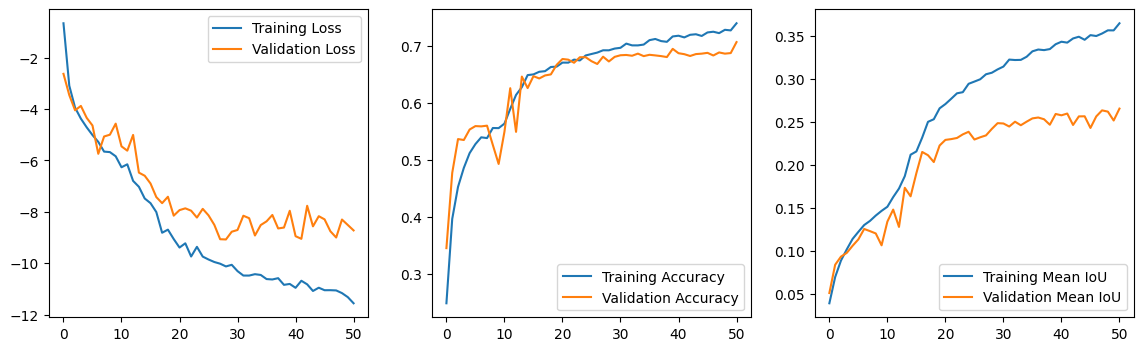

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(model_history.history['loss'], label='Training Loss')
ax[0].plot(model_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(model_history.history['acc'], label='Training Accuracy')
ax[1].plot(model_history.history['val_acc'], label='Validation Accuracy')
ax[1].legend()

ax[2].plot(model_history.history['mean_io_u'], label='Training Mean IoU')
ax[2].plot(model_history.history['val_mean_io_u'], label='Validation Mean IoU')
ax[2].legend();
plt.savefig('./imgs/dice_seg_training_curves.png');

Categorical Crossentropy Loss Model


In [24]:
OUTPUT_CLASSES = 24

model2 = unet_model(output_channels=OUTPUT_CLASSES, name = 'cc_seg')
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc',
                       tf.keras.metrics.MeanIoU(num_classes=24, sparse_y_pred=False, sparse_y_true=False)])

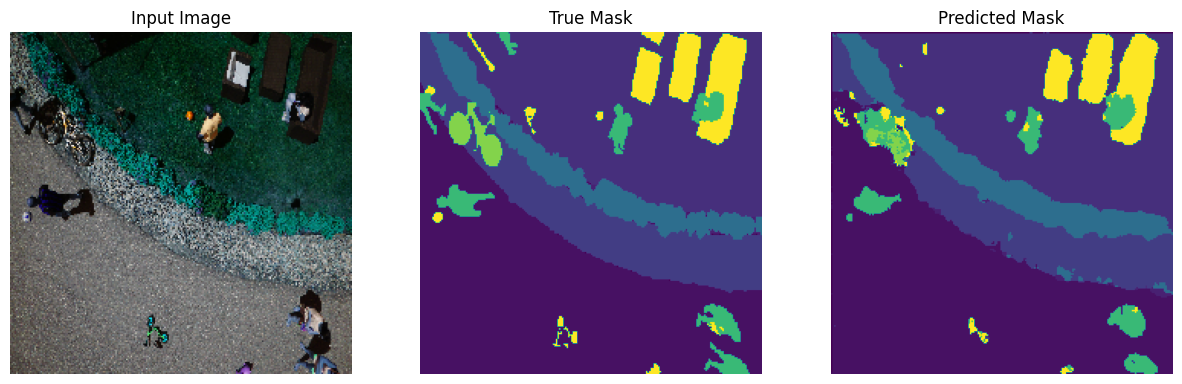


Sample Prediction after epoch 51

20/20 [==============================] - 32s 2s/step - loss: 0.4699 - acc: 0.8536 - mean_io_u_1: 0.4940 - val_loss: 0.8631 - val_acc: 0.7715 - val_mean_io_u_1: 0.3616


In [25]:
EPOCHS = 51

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('seg_model_cc.h5', 
                                                   save_best_only=True,
                                                   save_weights_only=True)

model2_history = model2.fit(train_generator, epochs=EPOCHS,
                          validation_data=val_generator,
                          callbacks=[DisplayCallback(), checkpoint_cb])

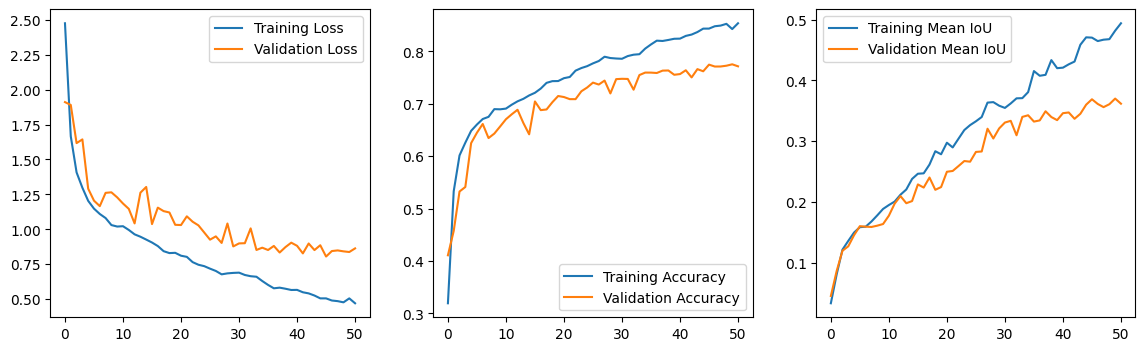

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(model2_history.history['loss'], label='Training Loss')
ax[0].plot(model2_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(model2_history.history['acc'], label='Training Accuracy')
ax[1].plot(model2_history.history['val_acc'], label='Validation Accuracy')
ax[1].legend()

ax[2].plot(model2_history.history['mean_io_u_1'], label='Training Mean IoU')
ax[2].plot(model2_history.history['val_mean_io_u_1'], label='Validation Mean IoU')
ax[2].legend()
plt.savefig('./imgs/cc_seg_training_curves.png')

In [31]:
!zip -r imgs imgs

  adding: imgs/ (stored 0%)
  adding: imgs/cc_seg_10_pred_mask.png (deflated 3%)
  adding: imgs/cc_seg_40_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_0_pred_mask.png (deflated 2%)
  adding: imgs/cc_seg_0_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_30_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_10_pred_mask.png (deflated 2%)
  adding: imgs/None_0_pred_mask.png (deflated 2%)
  adding: imgs/dice_seg_20_pred_mask.png (deflated 3%)
  adding: imgs/cc_seg_20_pred_mask.png (deflated 3%)
  adding: imgs/cc_seg_50_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_40_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_50_pred_mask.png (deflated 3%)
  adding: imgs/dice_seg_training_curves.png (deflated 6%)
  adding: imgs/cc_seg_training_curves.png (deflated 6%)
  adding: imgs/cc_seg_30_pred_mask.png (deflated 3%)
